# 感情曲線の考察

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [3]:
import pickle
def save_instance(obj, file_path):
    with open(file_path, 'wb') as p:
        pickle.dump(obj, p)

def load_instance(file_path):
    with open(file_path, 'rb') as p:
        return pickle.load(p)

## 関数定義

In [4]:
class AozoraTSKmeas:

    def __init__(self, n_clusters, metrics='dtw', random_state=0):
        self.tskmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, random_state=random_state)

    def fit_transform(self, A):
        self.A = A
        self.distances = self.tskmeans.fit_transform(self.A)
    
    # 分類されたクラスタを表示
    def show_cluster(self, suptitle, title, n_row=3, n_col=3):
        center = self.tskmeans.cluster_centers_[:,:,0]
        plt.figure(figsize=(15, 10))
        plt.suptitle(suptitle, fontsize=20)
        for i in np.arange(len(center)):
            ax = plt.subplot(n_row, n_col, i+1)
            ax.set_title(f'{title}:{i+1}', fontsize=15)
            ax.plot(center[i])
        plt.tight_layout()
        plt.show()

    # クラスタとクラスタに近いデータを表示
    """
    Parameters
    ----------
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    label_num: ラベル表示数
    """
    def show_cluster_sumples(self, aozora_data,
                            disp_num=20, label_num=5, 
                            figsize=(15, 15), plot_rows=3, plot_cols=3):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        plt.figure(figsize=figsize)
        suptitle = f'tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters={n_clusters}]'
        plt.suptitle(suptitle, fontsize=20)
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # グラフ表示
            cell = label + 1
            ax = plt.subplot(plot_rows, plot_cols, cell)
            count = len(distance_dicts_sort_key)
            top_stories = []
            ax.set_title(f'center{cell} ({count})', fontsize=15)
            for idx in distance_dicts_sort_key[:disp_num]:
                ax.plot(self.A[idx], alpha=.5, c='gray')
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                top_stories.append(f'{novel} ({author})\n{url}')
            xlabel = 'Top Stories:\n'
            for i in range(label_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            ax.set_xlabel(xlabel, loc='left', fontsize=15)
            # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
            plt.plot(self.tskmeans.cluster_centers_[label].ravel(), c='red')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
    
    # クラスタに近い小説を表示
    """
    Parameters
    ----------
    kmeans: TimeSeriesKMenasのインスタンス
    distances: 中心からの距離
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    """
    def show_novels(self, aozora_data, disp_num=20):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        print(f'CLUSTER NUM:{n_clusters}')
        print('NO: 作品名 [副題] (作者,文の長さ)\n')
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # クラスタに近い小説を表示
            top_stories = []
            for idx in distance_dicts_sort_key[:disp_num]:
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                subtitle = aozora_data.iloc[idx].loc['副題']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                length = int(aozora_data.iloc[idx].loc['length'])
                if type(subtitle) is float:
                    top_stories.append(f'{novel} ({author},{length})\n{url}')
                else:
                    top_stories.append(f'{novel} [{subtitle}] ({author},{length})\n{url}')
            xlabel = f'Top Stories of center{label+1}:\n'
            for i in range(disp_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            print(xlabel)

In [5]:
def get_labels_values(tskm):
    n_clusters = len(np.unique(tskm.tskmeans.labels_))
    fig_values, fig_labels = [], []
    for label in range(n_clusters):
        keys = np.where(tskm.tskmeans.labels_==label)[0]
        values = tskm.distances[tskm.tskmeans.labels_==label][:, label]
        # print(f'cluster{label+1}: {len(keys)}')
        fig_labels.append(f'cluster{label+1}')
        fig_values.append(len(keys))
    return fig_values, fig_labels

## クラスタリングの結果をロード

In [6]:
# クラスタ数:4で実施
file_path = 'data/km4_1209.bin'
km4 = load_instance(file_path)
fig_values4, fig_labels4 = get_labels_values(km4)
fig_values4, fig_labels4

([320, 213, 338, 278], ['cluster1', 'cluster2', 'cluster3', 'cluster4'])

In [7]:
# クラスタ数:5で実施
file_path = 'data/km5_1209.bin'
km5 = load_instance(file_path)
fig_values5, fig_labels5 = get_labels_values(km5)
fig_values5, fig_labels5

([277, 181, 238, 209, 244],
 ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5'])

In [8]:
# クラスタ数:6で実施
file_path = 'data/km6_1209.bin'
km6 = load_instance(file_path)
fig_values6, fig_labels6 = get_labels_values(km6)
fig_labels6, fig_values6

(['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6'],
 [225, 163, 159, 165, 230, 207])

In [9]:
# クラスタ数:7で実施
file_path = 'data/km7_1209.bin'
km7 = load_instance(file_path)
fig_values7, fig_labels7 = get_labels_values(km7)
fig_labels7, fig_values7

(['cluster1',
  'cluster2',
  'cluster3',
  'cluster4',
  'cluster5',
  'cluster6',
  'cluster7'],
 [180, 156, 176, 155, 161, 159, 162])

In [10]:
# クラスタ数:8で実施
file_path = 'data/km8_1209.bin'
km8 = load_instance(file_path)
fig_values8, fig_labels8 = get_labels_values(km8)
fig_labels8, fig_values8

(['cluster1',
  'cluster2',
  'cluster3',
  'cluster4',
  'cluster5',
  'cluster6',
  'cluster7',
  'cluster8'],
 [176, 147, 191, 127, 108, 142, 140, 118])

In [11]:
# クラスタ数:9で実施
file_path = 'data/km9_1209.bin'
km9 = load_instance(file_path)
fig_values9, fig_labels9 = get_labels_values(km9)
fig_labels9, fig_values9

(['cluster1',
  'cluster2',
  'cluster3',
  'cluster4',
  'cluster5',
  'cluster6',
  'cluster7',
  'cluster8',
  'cluster9'],
 [166, 133, 165, 119, 103, 121, 95, 103, 144])

## 円グラフ

In [12]:
def draw_pi(labels, values):
    plt.title(f'クラスタ数:{len(labels)}', fontsize=30, pad=0)
    colors = [str(round(x,1)) for x in np.linspace(0.9, 0.2, num=len(values))]
    patches, texts, rates = plt.pie(values, 
                         labels=labels, 
                         counterclock=False, 
                         startangle=90, 
                        #  labeldistance=0.9,
                         radius=1, 
                         autopct="%.1f%%",
                         colors=colors,
                        #  textprops={'color': 'white', 'weight': 'bold'}
                        )
    return patches, texts, rates, colors

In [13]:
def label_alignment(texts, colors, rates):
    for t, c, r in zip(texts, colors, rates):
        # t.set_horizontalalignment('center')
        # t.set_verticalalignment('top')
        t.set_color('black')
        r.set_verticalalignment('bottom')
        if float(c) <= 0.5:
            # t.set_color('white')
            r.set_color('white')
        else:
            # t.set_color('gray')
            r.set_color('black')
        t.set_size(18)
        r.set_size(16)

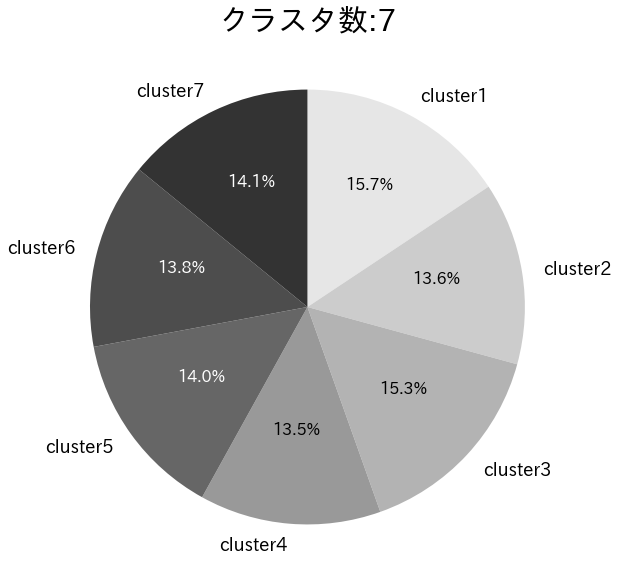

In [14]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('white')
patches, texts, rates, colors = draw_pi(fig_labels7, fig_values7)
label_alignment(texts, colors, rates)
plt.show()

## クラスタリング結果

In [15]:
def show_cluster_sumples(tskm, aozora_data,
                            disp_num=20, label_num=5, 
                            figsize=(15, 15), plot_rows=3, plot_cols=3, strong_no=10000):
        n_clusters = len(np.unique(tskm.tskmeans.labels_)) 
        plt.figure(figsize=figsize)
        suptitle = f'tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters={n_clusters}]'
        plt.suptitle(suptitle, fontsize=20)
        for label in range(n_clusters):
            keys = np.where(tskm.tskmeans.labels_==label)[0]
            values = tskm.distances[tskm.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # グラフ表示
            cell = label + 1
            ax = plt.subplot(plot_rows, plot_cols, cell)
            count = len(distance_dicts_sort_key)
            top_stories = []
            ax.set_title(f'クラスタ{cell} ({count})', fontsize=25)
            # ax.set_title(f'クラスタ{cell} ', fontsize=20)
            for no, idx in enumerate(distance_dicts_sort_key[:disp_num]):
                if (no==strong_no-1):
                    ax.plot(tskm.A[idx], c='blue')
                else:
                    ax.plot(tskm.A[idx], alpha=.5, c='gray')
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                # top_stories.append(f'{novel} ({author})\n{url}')
                top_stories.append(f'{novel} ({author})')
                # top_stories.append(f'{novel} ({author})')
            xlabel = 'Top Stories:\n'
            for i in range(label_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            ax.set_xlabel(xlabel, loc='left', fontsize=15)
            ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
            plt.plot(tskm.tskmeans.cluster_centers_[label].ravel(), linewidth=2, c='red')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

In [16]:
# 使うデータは1149冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_1205.csv'
TARGET_PATH = 'data/target2.csv'

In [17]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
print(score_df.shape)
score_df.head(3)

(1149, 100)


,S00,S01,S02,S03,S04,S05,S06,S07,S08,S09,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
13,0.025661,0.000000,0.054238,0.066828,0.170504,0.276141,0.331507,0.199721,0.145354,0.078378,...,0.730720,0.769252,0.744509,0.796472,0.747293,0.633655,0.644652,0.587357,0.710778,1.000000
19,0.582563,0.548885,0.555228,0.577744,0.582888,0.640445,0.639444,0.669647,0.633042,0.589699,...,0.581338,0.537401,0.493915,0.504167,0.462203,0.416233,0.410606,0.407270,0.372276,0.337727
24,0.558150,0.573397,0.559897,0.556415,0.527930,0.403733,0.370236,0.465665,0.523025,0.457648,...,0.028671,0.000000,0.009338,0.099273,0.117307,0.078283,0.066041,0.078662,0.093908,0.292288


In [18]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
print(target_df.shape)
# target_df.head(2)

(3442, 14)


In [19]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
print(df_merge_all.shape)
# df_merge_all.head(2)

(1149, 114)


In [20]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head(2)

,TargetID,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
0,13,True,879,芥川 竜之介,あくたがわ りゅうのすけ,124,お律と子等と,NaN,おりつとこらと,https://www.aozora.gr.jp/cards/000879/card124....,...,0.730720,0.769252,0.744509,0.796472,0.747293,0.633655,0.644652,0.587357,0.710778,1.000000
1,19,True,879,芥川 竜之介,あくたがわ りゅうのすけ,69,河童,NaN,かっぱ,https://www.aozora.gr.jp/cards/000879/card69.html,...,0.581338,0.537401,0.493915,0.504167,0.462203,0.416233,0.410606,0.407270,0.372276,0.337727


In [21]:
# スコアだけ取得
scores = df_merge.loc[:,'S00':].to_numpy()

In [22]:
import collections
# クラスタに近い小説を表示
def show_novels(tskm, aozora_data, disp_num=20):
    n_clusters = len(np.unique(tskm.tskmeans.labels_)) 
    print(f'CLUSTER NUM:{n_clusters}')
    print('NO: 作品名 [副題] (作者,文の長さ)\n')
    top_stories = []
    for label in range(n_clusters):
        keys = np.where(tskm.tskmeans.labels_==label)[0]
        values = tskm.distances[tskm.tskmeans.labels_==label][:, label]
        distance_dicts = {k: v for k, v in zip(keys, values)}
        distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
        distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
        # print(label, distance_dicts_sort_key[:20])
        # クラスタに近い小説を表示
        # top_stories = []
        author_list = []
        for idx in distance_dicts_sort_key:
            author = aozora_data.iloc[idx].loc['氏名']
            novel = aozora_data.iloc[idx].loc['作品名']
            subtitle = aozora_data.iloc[idx].loc['副題']
            url = aozora_data.iloc[idx].loc['図書カードURL']
            length = int(aozora_data.iloc[idx].loc['length'])
            if type(subtitle) is float:
                subtitle = ''
            author_list.append(author)
            dict = {'cluster': label+1, '著者': author, '作品名': novel, '副題': subtitle, 'url': url, 'length': length}
            top_stories.append(dict)
            
        # c = collections.Counter(author_list)
        # print(c)
        # print(f"cluster{label+1}: {c['夏目 漱石']}")
        # xlabel = f'Top Stories of center{label+1}:\n'
        # for i in range(len(top_stories)):
        #     xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
        # print(xlabel)
    return top_stories

In [23]:
stories = show_novels(km7, df_merge)

CLUSTER NUM:7
NO: 作品名 [副題] (作者,文の長さ)



In [24]:
df_stories = pd.DataFrame(stories)
df_stories

,cluster,著者,作品名,副題,url,length
0,1,島崎 藤村,桜の実の熟する時,,https://www.aozora.gr.jp/cards/000158/card5030...,3087
1,1,宮本 百合子,栄蔵の死,,https://www.aozora.gr.jp/cards/000311/card7908...,985
2,1,坂口 安吾,明治開化 安吾捕物,12 その十一 稲妻は見たり,https://www.aozora.gr.jp/cards/001095/card4321...,757
3,1,太宰 治,東京八景,（苦難の或人に贈る）,https://www.aozora.gr.jp/cards/000035/card1569...,824
4,1,佐々木 味津三,右門捕物帖,31 毒を抱く女,https://www.aozora.gr.jp/cards/000111/card561....,648
...,...,...,...,...,...,...
1144,7,泉 鏡花,星女郎,,https://www.aozora.gr.jp/cards/000050/card4743...,1586
1145,7,吉川 英治,鳴門秘帖,03 木曾の巻,https://www.aozora.gr.jp/cards/001562/card5240...,1538
1146,7,泉 鏡花,悪獣篇,,https://www.aozora.gr.jp/cards/000050/card4563...,1089
1147,7,宮本 百合子,道標,,https://www.aozora.gr.jp/cards/000311/card2012...,21441


In [28]:
pd.crosstab(index=df_stories['著者'], columns=df_stories['cluster'], margins=True).sort_values('All', ascending=False)

cluster,1,2,3,4,5,6,7,All
著者,,,,,,,,
All,180,156,176,155,161,159,162,1149
吉川 英治,12,5,13,9,21,9,18,87
山本 周五郎,12,9,8,5,10,13,5,62
野村 胡堂,5,7,7,14,9,10,10,62
豊島 与志雄,8,7,9,9,11,3,8,55
...,...,...,...,...,...,...,...,...
田畑 修一郎,0,0,0,0,1,0,0,1
白柳 秀湖,0,0,0,0,0,1,0,1
梶井 基次郎,0,0,0,0,0,1,0,1


In [26]:
df_stories.to_excel('stories.xlsx')